In [16]:
import os
import cv2
import numpy as np
from skimage.filters import threshold_otsu, threshold_sauvola
from sklearn.metrics import jaccard_score
from tqdm import tqdm  

def dice_score(gt, pred):
    gt_bin = (gt > 0).astype(np.uint8)
    pred_bin = (pred > 0).astype(np.uint8)
    gt_sum = gt_bin.sum()
    pred_sum = pred_bin.sum()
    if gt_sum == 0 and pred_sum == 0:
        return 1.0
    intersection = (gt_bin & pred_bin).sum()
    return 2.0 * intersection / (gt_sum + pred_sum)

In [17]:
def safe_jaccard(gt, pred):
    """Return Jaccard (IoU). If both empty, return 1.0."""
    gt_bin = (gt > 0).astype(np.uint8).flatten()
    pred_bin = (pred > 0).astype(np.uint8).flatten()
    if gt_bin.sum() == 0 and pred_bin.sum() == 0:
        return 1.0
    return jaccard_score(gt_bin, pred_bin, average='binary')

In [18]:
def otsu_segmentation(image):
    thresh = threshold_otsu(image)
    binary = image > thresh
    return binary.astype(np.uint8)


In [19]:
image_path = "/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation/images"  
mask_path  = "/kaggle/input/datasets/nikhilroxtomar/brain-tumor-segmentation/masks"    
resize_to = (256, 256)          

In [20]:
def sauvola_segmentation(image):
    window_size = 51
    thresh = threshold_sauvola(image, window_size=window_size)
    binary = image > thresh
    return binary.astype(np.uint8)

In [21]:
image_files = sorted([f for f in os.listdir(image_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

In [22]:
dice_otsu_list = []
dice_sauvola_list = []
jaccard_otsu_list = []
jaccard_sauvola_list = []
skipped = []

In [23]:
for fname in tqdm(image_files, desc="Processing images"):
    img_fp = os.path.join(image_path, fname)
    mask_fp = os.path.join(mask_path, fname)
    if not os.path.exists(mask_fp):
        skipped.append(fname)
        continue

    img = cv2.imread(img_fp, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_fp, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        skipped.append(fname)
        continue

   
    img = cv2.resize(img, resize_to)
    mask = cv2.resize(mask, resize_to, interpolation=cv2.INTER_NEAREST)

    mask_bin = (mask > 127).astype(np.uint8)

 
    otsu_thresh = threshold_otsu(img)
    otsu_seg = (img > otsu_thresh).astype(np.uint8)

    
    sauvola_thresh = threshold_sauvola(img, window_size=25, k=0.2)
    sauvola_seg = (img > sauvola_thresh).astype(np.uint8)

    

    d_otsu = dice_score(mask_bin, otsu_seg)
    d_sauvola = dice_score(mask_bin, sauvola_seg)
    j_otsu = safe_jaccard(mask_bin, otsu_seg)
    j_sauvola = safe_jaccard(mask_bin, sauvola_seg)

    dice_otsu_list.append(d_otsu)
    dice_sauvola_list.append(d_sauvola)
    jaccard_otsu_list.append(j_otsu)
    jaccard_sauvola_list.append(j_sauvola)

Processing images: 100%|██████████| 3064/3064 [01:41<00:00, 30.15it/s]


In [24]:

print("\nPer-image results (first 10 shown):")
for i, fname in enumerate(image_files[:10]):
    if i >= len(dice_otsu_list):
        break
    print(f"{fname:30} | Otsu Dice: {dice_otsu_list[i]:.4f}  Sauvola Dice: {dice_sauvola_list[i]:.4f}  "
          f"Otsu IoU: {jaccard_otsu_list[i]:.4f}  Sauvola IoU: {jaccard_sauvola_list[i]:.4f}")


Per-image results (first 10 shown):
1.png                          | Otsu Dice: 0.1036  Sauvola Dice: 0.0709  Otsu IoU: 0.0546  Sauvola IoU: 0.0367
10.png                         | Otsu Dice: 0.0853  Sauvola Dice: 0.0525  Otsu IoU: 0.0446  Sauvola IoU: 0.0270
100.png                        | Otsu Dice: 0.0517  Sauvola Dice: 0.0413  Otsu IoU: 0.0266  Sauvola IoU: 0.0211
1000.png                       | Otsu Dice: 0.0283  Sauvola Dice: 0.0193  Otsu IoU: 0.0144  Sauvola IoU: 0.0098
1001.png                       | Otsu Dice: 0.0308  Sauvola Dice: 0.0214  Otsu IoU: 0.0156  Sauvola IoU: 0.0108
1002.png                       | Otsu Dice: 0.0245  Sauvola Dice: 0.0170  Otsu IoU: 0.0124  Sauvola IoU: 0.0086
1003.png                       | Otsu Dice: 0.0333  Sauvola Dice: 0.0259  Otsu IoU: 0.0170  Sauvola IoU: 0.0131
1004.png                       | Otsu Dice: 0.0275  Sauvola Dice: 0.0211  Otsu IoU: 0.0139  Sauvola IoU: 0.0107
1005.png                       | Otsu Dice: 0.0218  Sauvola Dice: 0

In [25]:
# Print overall averages
def mean_or_nan(xs):
    return float(np.nan) if len(xs)==0 else float(np.mean(xs))

print("\nSUMMARY:")
print(f"Otsu mean Dice   : {mean_or_nan(dice_otsu_list):.4f}")
print(f"Sauvola mean Dice: {mean_or_nan(dice_sauvola_list):.4f}")
print(f"Otsu mean IoU    : {mean_or_nan(jaccard_otsu_list):.4f}")
print(f"Sauvola mean IoU : {mean_or_nan(jaccard_sauvola_list):.4f}")

if skipped:
    print(f"\nSkipped {len(skipped)} files (missing or unreadable): {skipped[:10]}")


SUMMARY:
Otsu mean Dice   : 0.0708
Sauvola mean Dice: 0.0474
Otsu mean IoU    : 0.0377
Sauvola mean IoU : 0.0247


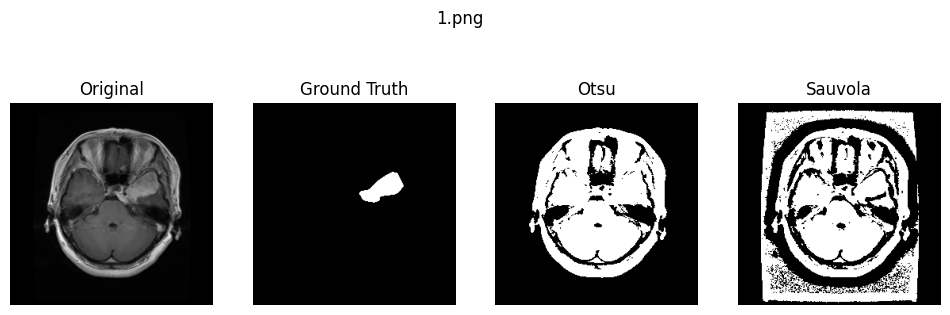

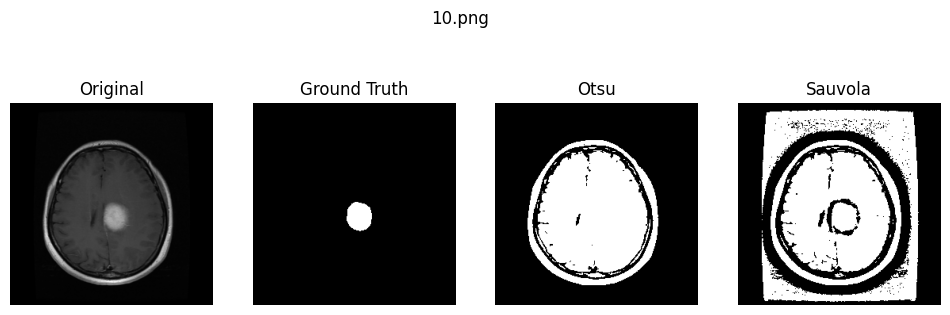

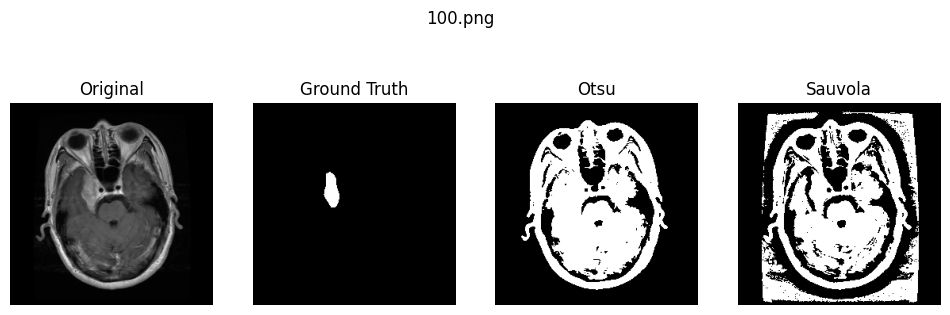

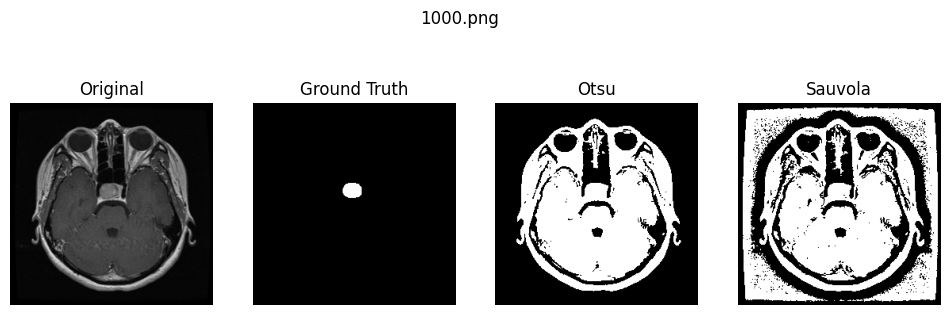

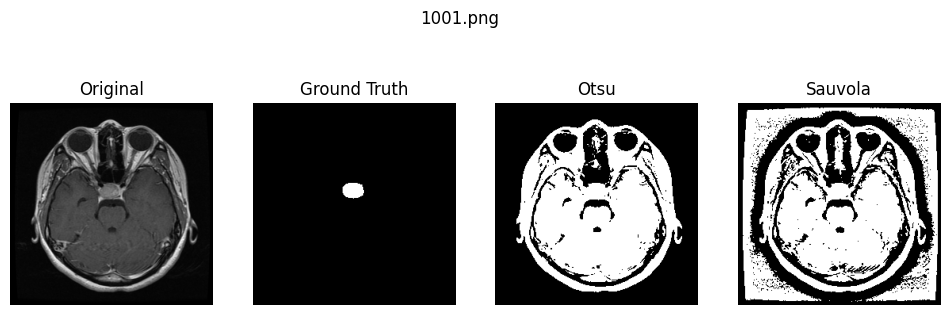

In [26]:
import matplotlib.pyplot as plt


num_samples = 5

for i in range(num_samples):
    
    file = filenames[i]
    
    img = cv2.imread(os.path.join(image_path, file), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(mask_path, file), cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, resize_size)
    mask = cv2.resize(mask, resize_size, interpolation=cv2.INTER_NEAREST)
    mask_bin = (mask > 127).astype(np.uint8)
    
    otsu_thresh = threshold_otsu(img)
    otsu_seg = (img > otsu_thresh).astype(np.uint8)
    
    sauvola_thresh = threshold_sauvola(img, window_size=25, k=0.2)
    sauvola_seg = (img > sauvola_thresh).astype(np.uint8)
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,4,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1,4,2)
    plt.imshow(mask_bin, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(1,4,3)
    plt.imshow(otsu_seg, cmap='gray')
    plt.title("Otsu")
    plt.axis("off")
    
    plt.subplot(1,4,4)
    plt.imshow(sauvola_seg, cmap='gray')
    plt.title("Sauvola")
    plt.axis("off")
    
    plt.suptitle(file)
    plt.show()


In [27]:
print(len(image_files))


3064
